In [1]:
# !pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import logging
import multiprocessing
from datetime import datetime, timedelta

from src import modules as f
%load_ext autoreload
%autoreload 2

In [3]:
# Download, load, extract, model...
interval = '1d'
stock_set = f.download_interval_process(interval, 1)
print(f'Stock set: \n{stock_set}\n')

Stock set: 
{'EXC', 'GS', 'OKE', 'IBM', 'ADBE', 'BSX', 'EXE', 'NEE', 'GOOG', 'XOM', 'WSM', 'DASH', 'CRM', 'AEP', 'PM', 'CSCO', 'JPM', 'WMT', 'DKNG', 'AVGO', 'GOOGL', 'DECK', 'MSFT', 'MO', 'AMZN', 'NFLX', 'WMB', 'COP', 'EOG', 'SRE', 'TTWO', 'FWONK', 'PEP', 'APH', 'TDG', 'SO', 'ATO', 'PG', 'PSX', 'XEL', 'NRG', 'TMO', 'WELL', 'AAPL', 'KMI', 'TGT', 'MA', 'T', 'LLY', 'ABT', 'HD', 'AXP', 'KO', 'VST', '^VIX', 'TMUS', 'NVDA', 'MDLZ', 'CVX', 'WFC', 'UNH', 'ISRG', 'BAC', 'JNJ', 'DUK', 'SW', 'TSLA', 'DIS', 'ORCL', 'SPGI', 'CMCSA', 'RCL', 'AMGN', 'BRK-B', 'SLB', 'CEG', 'FCNCA', 'D', 'PLTR', 'AJG', 'MSI', 'MRK', 'LNG', 'CL', 'ACN', 'ABBV', 'COST', 'TPR', 'PGR', 'V', 'VZ', 'META'}



In [4]:
# f.make_table_features_process(stock_set, interval, 8)
# f.make_master_table(stock_set, interval)
# f.xg_boost_model(interval='1d', grid_search_on=True)

In [5]:
symbol = 'TSLA'.upper()
interval = '1d'
f.model_prospect(symbol, interval, build=False)
df_val = f.model_validation(symbol, interval)
correctly_predicted = df_val.dir_pred_match.sum()
print(f'\nCorrectly Predicted: {correctly_predicted}')
entries_predicted = df_val.shape[0]
print(f'Entries Predicted: {entries_predicted}')
print(f'Percent Correct: {correctly_predicted / entries_predicted}')

$TSLA: possibly delisted; no price data found  (1d 1926-05-01 -> 2025-04-06)
ERROR:root:Failed to download ticker TSLA due to: "['dividends', 'stock_splits'] not found in axis"



Model Prediction 1d TSLA:
Predicted Next 1d Movement: UP

Model Prediction Probabilities:
no_change (0): 0.3398
up (1): 0.3494
down (2): 0.3108

Last Entry 1d TSLA Datetime Used for Prediction:
NOTE: It's in or contains the full 1d time interval.
EST: 2025-04-04 12:00:00 AM EDT-0400
PDT: 2025-04-03 09:00:00 PM PDT-0700

Correctly Predicted: 13
Entries Predicted: 50
Percent Correct: 0.26


In [6]:
# !pip install pmdarima statsmodels prophet

In [7]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

stock_symbol = 'NVDA'.upper()
interval = '1d'
stock_data = f.load_raw(stock_symbol, interval)
stock_data

,open,high,low,close,adj_close,volume
Date,,,,,,
1999-01-22 00:00:00-05:00,0.043750,0.048828,0.038802,0.041016,0.037612,2714688000
1999-01-25 00:00:00-05:00,0.044271,0.045833,0.041016,0.045313,0.041552,510480000
1999-01-26 00:00:00-05:00,0.045833,0.046745,0.041146,0.041797,0.038328,343200000
1999-01-27 00:00:00-05:00,0.041927,0.042969,0.039583,0.041667,0.038209,244368000
1999-01-28 00:00:00-05:00,0.041667,0.041927,0.041276,0.041536,0.038089,227520000
...,...,...,...,...,...,...
2025-03-31 00:00:00-04:00,105.129997,110.959999,103.650002,108.379997,108.379997,299212700
2025-04-01 00:00:00-04:00,108.519997,110.199997,106.470001,110.150002,110.150002,222614000
2025-04-02 00:00:00-04:00,107.290001,111.980003,106.790001,110.419998,110.419998,220601200


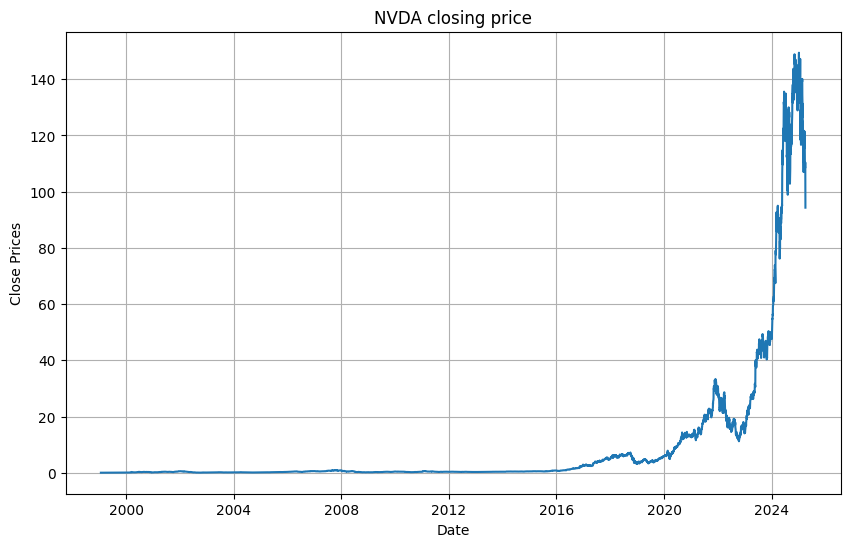

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['close'])
plt.title(f'{stock_symbol} closing price')
plt.show()

<Axes: ylabel='Density'>

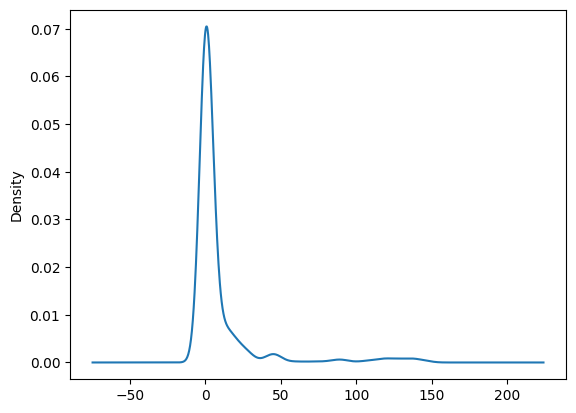

In [9]:
#Distribution of the dataset
df_close = stock_data['close']
df_close.plot(kind='kde')

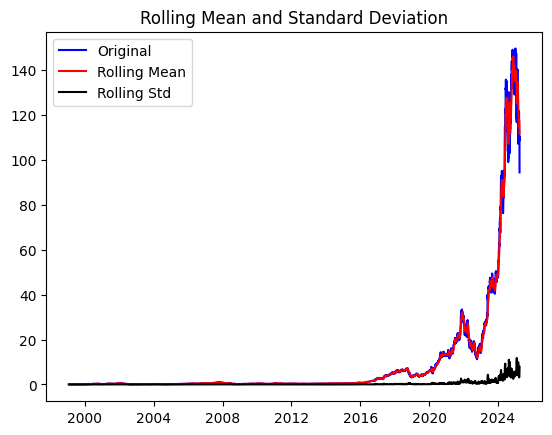

Results of dickey fuller test
Test Statistics                   0.227025
p-value                           0.973737
No. of lags used                 35.000000
Number of observations used    6556.000000
critical value (1%)              -3.431348
critical value (5%)              -2.861981
critical value (10%)             -2.567005
dtype: float64


In [10]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

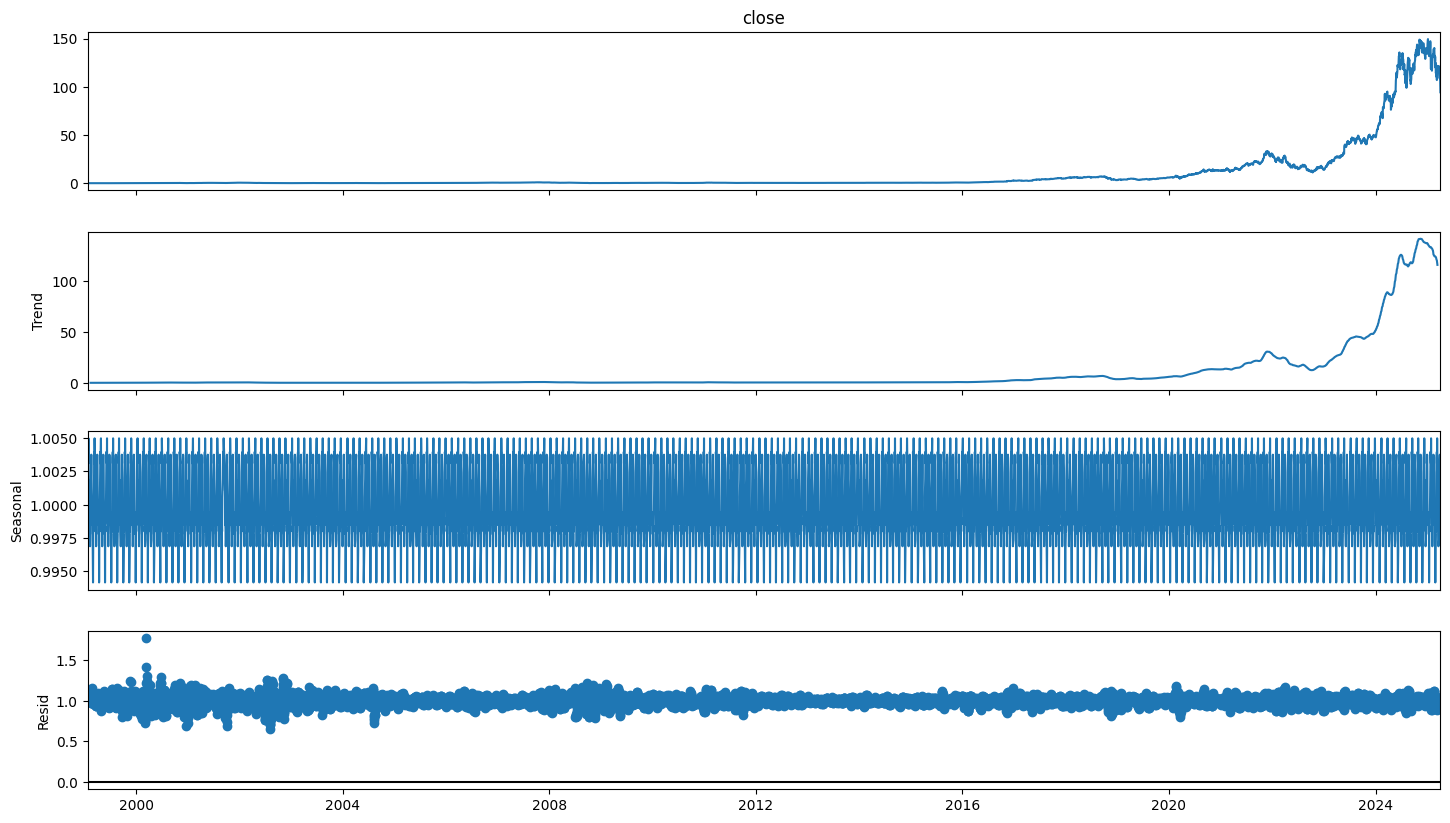

In [11]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

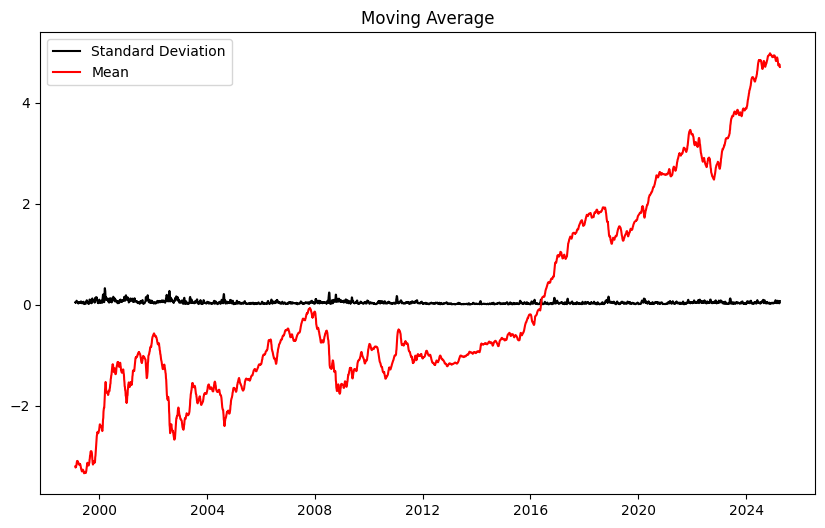

In [12]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

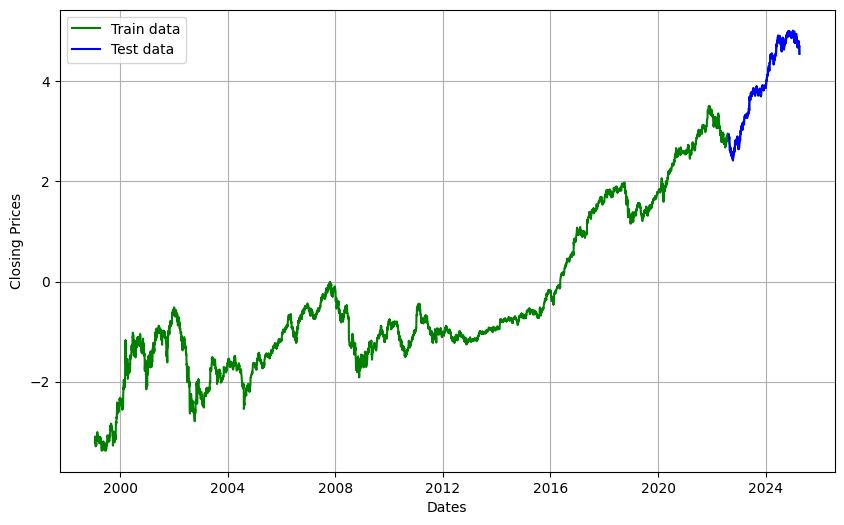

In [13]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21925.458, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21923.459, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21923.459, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21923.145, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21921.458, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.758 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5929
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10964.729
Date:                Sun, 06 Apr 2025   AIC                         -21925.458
Time:                        01:32:30   BIC                         -21912.083
Sample:                             0   HQIC                        -21920.810
                               - 5929                             

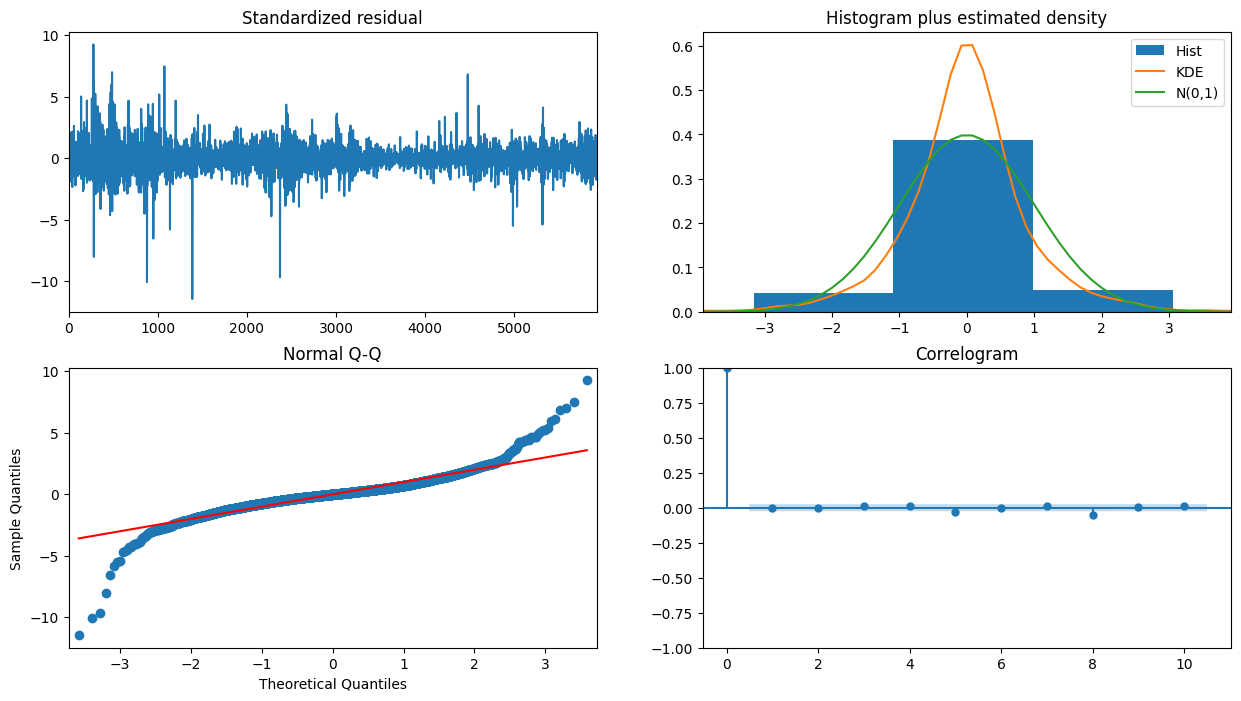

In [14]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [20]:
# As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.
#Modeling
# Build Model
train_data = train_data.asfreq('B')
model = ARIMA(train_data, order=(1, 1, 2), trend='t') 
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 6146
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10934.502
Date:                Sun, 06 Apr 2025   AIC                         -21859.004
Time:                        01:36:50   BIC                         -21825.387
Sample:                    01-27-1999   HQIC                        -21847.344
                         - 08-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0010      0.000      2.039      0.041    3.83e-05       0.002
ar.L1         -0.6844      1.359     -0.504      0.615      -3.349       1.980
ma.L1          0.6741      1.361      0.495      0.6

Training data last date: 2022-08-17 00:00:00
Test data first date: 2022-08-18 00:00:00


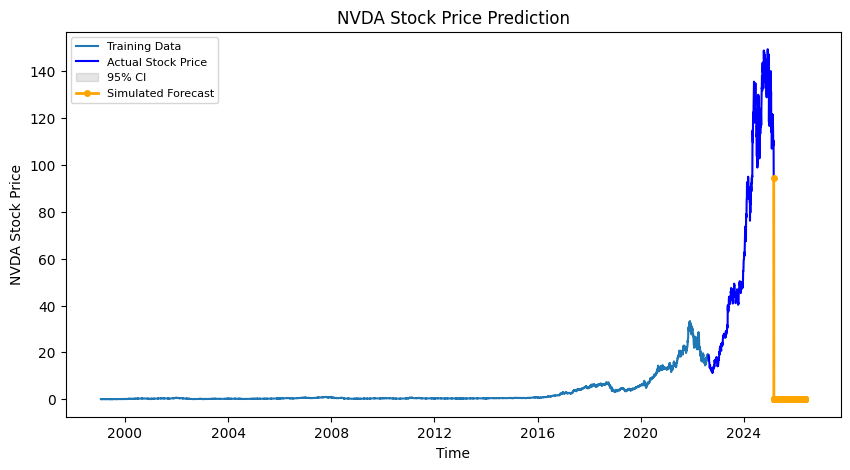

In [32]:
# Convert training data index to tz-naive (remove timezone)
train_data = train_data.copy()
train_data.index = train_data.index.tz_localize(None)

# Create a new index for test_data that extends train_data.
freq = train_data.index.inferred_freq or 'B'
new_index = pd.date_range(
    start=train_data.index[-1] + pd.Timedelta(days=1),
    periods=len(test_data),
    freq=freq
)
# Remove the frequency attribute by converting to a plain Index
new_index = pd.Index(new_index.tolist())

# Assign the new index to test_data
test_data = test_data.copy()
test_data.index = new_index

# Debug prints to verify index extension.
print("Training data last date:", train_data.index[-1])
print("Test data first date:", test_data.index[0])
assert test_data.index[0] > train_data.index[-1], "Test data index does not extend training data!"

# Append test_data to update the model's state.
fitted_updated = fitted.append(test_data, refit=False)

# Define forecast steps and simulation runs.
forecast_steps = 321
n_sim = 1000

# Simulate forecast paths from the updated model state.
simulated_paths = fitted_updated.simulate(nsimulations=forecast_steps, repetitions=n_sim)
if hasattr(simulated_paths, "to_numpy"):
    simulated_paths = simulated_paths.to_numpy()

# Compute the 2.5th and 97.5th percentiles (confidence intervals) for each forecast day.
lower_bound = np.percentile(simulated_paths, 2.5, axis=1)
upper_bound = np.percentile(simulated_paths, 97.5, axis=1)

# Select one simulation path (e.g., the first column) as the free-floating forecast.
fc_simulation = simulated_paths[:, 0]

# Create a forecast index starting from one day after test_data's last date.
forecast_index = pd.date_range(
    start=test_data.index[-1] + pd.Timedelta(days=1),
    periods=forecast_steps,
    freq=freq
)
forecast_index = pd.Index(forecast_index.tolist())  # Remove frequency attribute

# Convert simulation results into pandas Series.
fc_series = pd.Series(fc_simulation, index=forecast_index)
lower_series = pd.Series(lower_bound, index=forecast_index)
upper_series = pd.Series(upper_bound, index=forecast_index)

# Since the model was built on log-scale data, exponentiate the simulated outputs 
# to convert them back to actual price levels.
fc_series = np.exp(fc_series)
lower_series = np.exp(lower_series)
upper_series = np.exp(upper_series)

# Prepend the last observed test_data value (converted to level) to the forecast series
# and to the confidence bounds, so that the forecast line and intervals are continuous.
last_actual_value = np.exp(test_data.iloc[-1])
fc_series_full = pd.concat([pd.Series([last_actual_value], index=[test_data.index[-1]]), fc_series])
lower_series_full = pd.concat([pd.Series([last_actual_value], index=[test_data.index[-1]]), lower_series])
upper_series_full = pd.concat([pd.Series([last_actual_value], index=[test_data.index[-1]]), upper_series])

# Create a combined x-axis index: the last date from test_data plus the forecast dates.
full_index = pd.Index(list(test_data.index[-1:]) + list(forecast_index))

# Plot the results with improved layering and markers.
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(np.exp(train_data), label='Training Data', zorder=1)
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price', zorder=2)
plt.fill_between(lower_series_full.index, lower_series_full, upper_series_full,
                 color='k', alpha=0.10, label='95% CI', zorder=3)
plt.plot(fc_series_full.index, fc_series_full,
         color='orange', marker='o', markersize=4,
         linewidth=2, label='Simulated Forecast', zorder=4)
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_symbol} Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()